# Describe, diagnose, predict and prescribe overview
## Purpose
Demonstrate different analytic types on a simple system:
- Descriptive analytics
- Diagnostic analytics
- Predictive analytics
- Prescriptive analytics
## System
- d is a stochastic, autocorrelated disturbance
- u is a manipulated input
- y is a dependent KPI


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize

In [2]:
# Import data
df = pd.read_csv('../data/open_describe_diagnose_predict_prescribe_data.csv')
df

,u,d,y
0,1.735525,0.100000,1.063493
1,-6.517300,-0.344088,2.500777
2,-7.217231,-1.007994,2.526468
3,-2.971500,-1.178885,1.153627
4,1.961710,0.932658,0.933169
...,...,...,...
995,0.672172,3.791331,1.573927
996,4.724201,5.797804,1.277964
997,0.916174,3.661271,1.455695
998,4.890998,5.122870,1.166352


## Descriptive analytics
- Descriptive statistics
- Statistical visualization

In [3]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
u,1000.0,-0.168358,5.069254,-14.383053,-3.813165,-0.357395,3.481808,15.898238
d,1000.0,0.035696,3.783526,-9.926709,-2.370401,0.162513,2.661243,10.307783
y,1000.0,1.779196,0.717420,0.788850,1.177666,1.645606,2.251311,4.072072


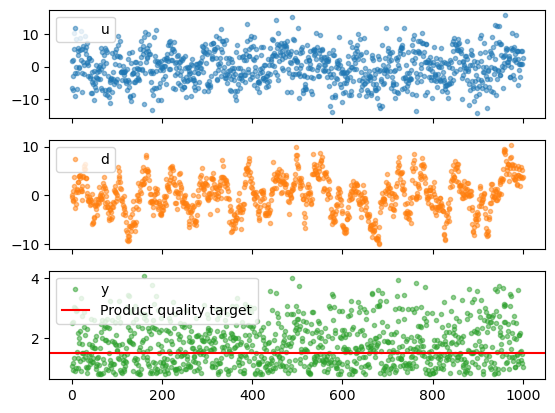

In [4]:
# Statistical visualization
# Time series
axx = df.plot(marker='.',ls='none',alpha=0.5,subplots=True)
axx[2].axhline(1.5,color='red',label='Product quality target')
axx[2].legend()

Text(0.5, 1.0, 'Fraction of samples meeting product quality target: 0.42')

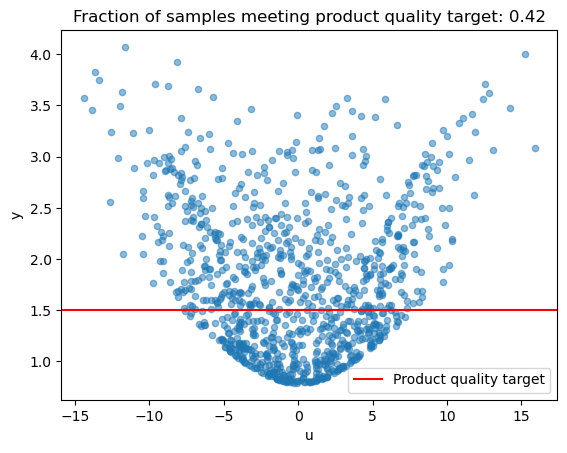

In [5]:
# Statistical visualization
# Scatter plot
ax = df.plot.scatter(x='u',y='y',alpha=0.5)
ax.axhline(1.5,color='red',label='Product quality target')
ax.legend()
fraction_spec = (df['y']<1.5).sum()/len(df['y'])
ax.set_title(f'Fraction of samples meeting product quality target: {fraction_spec:0.2f}')

<Axes: >

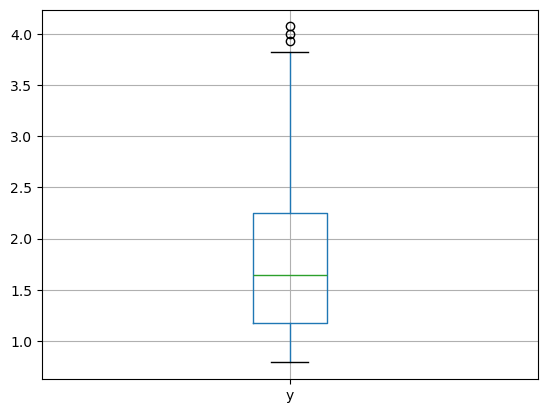

In [6]:
# Statistical visualization
# Box plot
df.boxplot(column='y')

## Diagnostic analytics: Model-based

In [7]:
# Modelling: Train models
X = df[['u','d']].copy()
Y = df['y'].copy()
lm = LinearRegression()
lm.fit(X.values,Y.values)
Ylm_hat = lm.predict(X.values)
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X.values,Y.values)
Yknn_hat = knn.predict(X.values)

In [8]:
# Modelling: Performance (on training data)
r2_lm = r2_score(Y.values,Ylm_hat)
mae_lm = mean_absolute_error(Y.values,Ylm_hat)
r2_knn = r2_score(Y.values,Yknn_hat)
mae_knn = mean_absolute_error(Y.values,Yknn_hat)
print(f'Linear regression: R2={r2_lm:0.2f}, MAE={mae_lm:0.2f}')
print(f'KNN regression: R2={r2_knn:0.2f}, MAE={mae_knn:0.2f}')


Linear regression: R2=0.00, MAE=0.59
KNN regression: R2=0.97, MAE=0.08


## Diagnostic analytics: Linear models
- Regression coefficients
- Linear effects plot

Linear model: Intercept 1.78


Text(0.5, 1.0, 'Linear model: Coefficients')

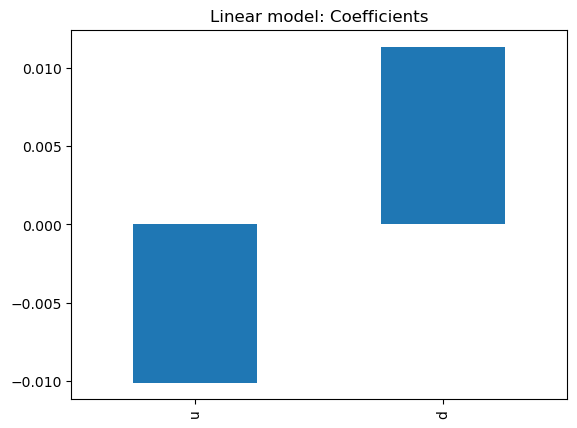

In [9]:
# Regression coefficients
print(f'Linear model: Intercept {lm.intercept_:0.2f}')
lm_coef = pd.Series(data=lm.coef_,index=['u','d'])
lm_coef.plot.bar()
plt.title('Linear model: Coefficients')

Text(0.5, 1.0, 'Linear regression: Effects plot')

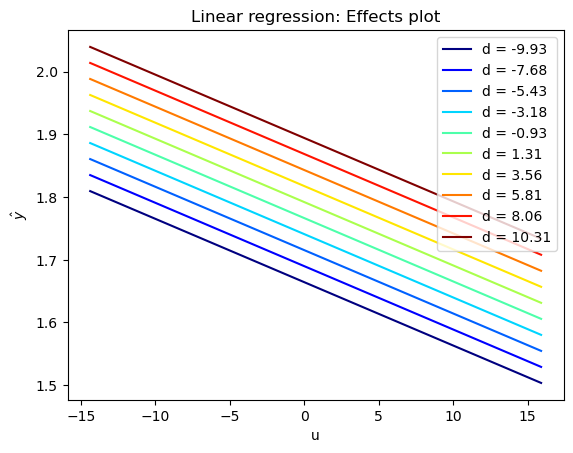

In [10]:
# Linear effects plot
ugrid = np.linspace(df['u'].min(),df['u'].max(),10)
Nu = len(ugrid)
dgrid = np.linspace(df['d'].min(),df['d'].max(),10)
Nd = len(dgrid)
fig, ax = plt.subplots()
ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, Nd)])
for d_current in dgrid:
    X_current = np.stack((ugrid,[d_current]*Nu),axis=1)
    ax.plot(ugrid,lm.predict(X_current),label='d = ' + str(round(d_current,2)))
ax.legend()
ax.set_xlabel('u')
ax.set_ylabel(r'$\hat{y}$')
ax.set_title('Linear regression: Effects plot')

## Diagnostic analytics: Nonlinear models
- Variable importance
- Nonlinear effects plot

Text(0.5, 1.0, 'Nonlinear model: Variable importance')

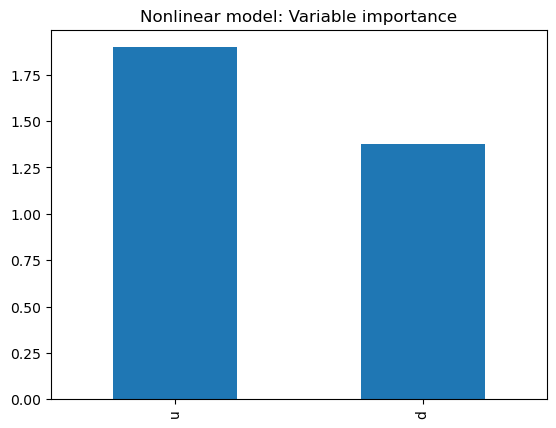

In [11]:
# Variable importance
vi = permutation_importance(knn,X.values,Y.values)
knn_vi = pd.Series(data=vi.importances_mean,index=['u','d'])
knn_vi.plot.bar()
plt.title('Nonlinear model: Variable importance')

Text(0.5, 1.0, 'Nonlinear regression: Effects plot')

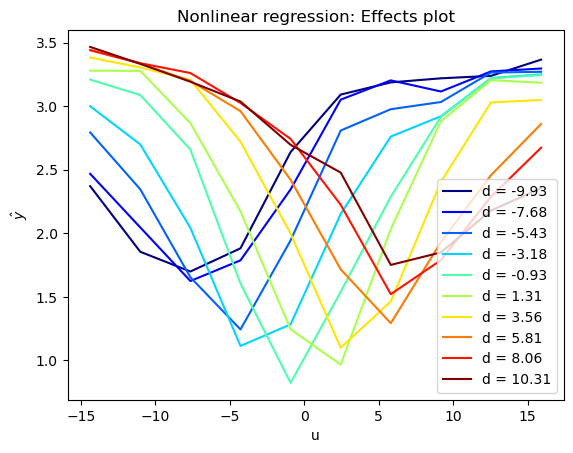

In [12]:
# Nonlinear effects plot
ugrid = np.linspace(df['u'].min(),df['u'].max(),10)
Nu = len(ugrid)
dgrid = np.linspace(df['d'].min(),df['d'].max(),10)
Nd = len(dgrid)
fig, ax = plt.subplots()
ax.set_prop_cycle('color',[plt.cm.jet(i) for i in np.linspace(0, 1, Nd)])
for d_current in dgrid:
    X_current = np.stack((ugrid,[d_current]*Nu),axis=1)
    ax.plot(ugrid,knn.predict(X_current),label='d = ' + str(round(d_current,2)))
ax.legend()
ax.set_xlabel('u')
ax.set_ylabel(r'$\hat{y}$')
ax.set_title('Nonlinear regression: Effects plot')

## Predictive analytics
- Future predictions for defined inputs (u and d)

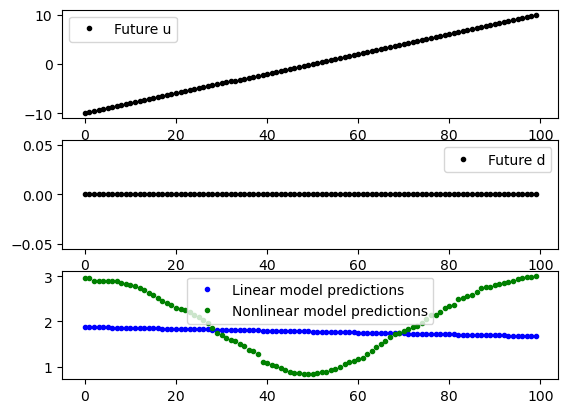

In [13]:
# Create future expectation of u and d
unext = np.linspace(-10,10,100)
dnext = np.zeros_like(unext)
X_next = np.stack((unext,dnext),axis=1)
# Create future predictions: Linear model
ypred_lm = lm.predict(X_next)
ypred_knn = knn.predict(X_next)
fig, axx = plt.subplots(3,1)
axx[0].plot(unext,'k.',label='Future u')
axx[0].legend()
axx[1].plot(dnext,'k.',label='Future d')
axx[1].legend()
axx[2].plot(ypred_lm,'b.',label='Linear model predictions')
axx[2].plot(ypred_knn,'g.',label='Nonlinear model predictions')
axx[2].legend()


# Prescriptive analytics
- Best u for fixed d

In [14]:
# Fixed d 
dfixed = -3

In [15]:
# Optimization objective function
def objective(u_val, d_val, model):
    X = np.vstack((u_val,d_val)).T
    y_pred = model.predict(X)
    return y_pred

In [16]:
# Optimization bounds
ubounds = [(-10,10)]
u0 = 5
result = minimize(objective,u0,args=(dfixed,knn),method='Nelder-Mead',bounds=ubounds)
ubest = result.x[0]
print(f'Best value for u, given d: {ubest:0.2f}')

Best value for u, given d: -2.62
